# Project I (Effective field theory modeling) - Bayesian parameter estimation as part of Chalmers TIF285

by Matthias Hübl & Linus Stach

## Imports, etc.

In [1]:
# Install tqdm and add it to the environment (pip install tqdm). It is not necessary. 
# However, it will give us a nice progress bar!
import tqdm

In [2]:
from quantumsolver import fewnucleonEmulator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from scipy import stats
import emcee
import corner

## Task 1

- How dense grid can you use given that each model evaluation takes $\lesssim 1$ ms and you would probably not like to wait more than $\sim$ minutes?

    Assume 1 minute => 60 seconds => 60,000 ms ~ 2^16 => 256x256 dimension

- How many data points would you naively need to infer two model parameters? If you were to combine the data that you have available, which set do you think works best for this inference problem?

    [To be answered]

### Define necessary constants, experimental data, etc.

In [13]:
# Define the size of our mesh
NcD = 8 #256
NcE = 8 #256
use_large_grid = True

# Other constants
k=3
cbar=1
Q=0.33

The experimental data is obtained from Table I) of the respective paper.

In [4]:
# Experimental data: Mu
mu_E3H=-8.482
mu_E4He=-28.296
mu_Rp4He=1.4552
mu_fT3H=1129.6

# Experimental data: Sigma
sigma_E3H=0.015
sigma_E4He=0.005
sigma_Rp4He=0.0062
sigma_fT3H=3

### Evaluate with quantum solver

Evaluate theoretical values with a quantum solver on a [-2.5, 2.5] X [-1, 1] grid.

In [5]:
# Create a 2-dimensional grid
# cD el [-2.5, 2.5]
# cE el [-1, 1]
cD = np.linspace(start=-2.5, stop=2.5, num=NcD)
cE = np.linspace(start=-1, stop=1, num=NcE)
cD_eval, cE_eval = np.meshgrid(cD,cE)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(fewnucleonEmulator)
E4He_eval, Rp4He_eval, Rch4He_eval, E3He_eval, E3H_eval, E1A3H_eval, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

In [18]:
if use_large_grid:
    NcE = 1028
    NcD = 1028
    cD = np.linspace(start=-2.5, stop=2.5, num=NcD)
    cE = np.linspace(start=-1, stop=1, num=NcE)
    cD_eval, cE_eval = np.meshgrid(cD,cE)
    results = np.load("./pool_outputs.npy")
    E4He_eval = results[:,0].reshape(NcE,NcD)
    Rp4He_eval = results[:,1].reshape(NcE,NcD)
    Rch4He_eval =results[:,2].reshape(NcE,NcD)
    E3He_eval = results[:,3].reshape(NcE,NcD)
    E3H_eval = results[:,4].reshape(NcE,NcD)
    E1A3H_eval = results[:,5].reshape(NcE,NcD)
    fT3H_eval = results[:,6].reshape(NcE,NcD)

### Define bayesian posterior distribution

In [15]:
# --- Prior ---

def prior(cD, cE):
    # cD and cE follow both a normal distribution ~ N(0,5)
    prior_dist = stats.norm(0, 5)  
    p1 = prior_dist.pdf(cD)
    p2 = prior_dist.pdf(cE)
    p1[np.abs(cD)>2.5] = 0
    p2[np.abs(cE)>1.] = 0
    prior = np.outer(p2, p1)
    return prior

# --- Likelihood ---

def likelihood(data, mu, sigma):
    likelihood_dist = stats.norm(mu, sigma)
    likelihood = likelihood_dist.pdf(data)
    return likelihood

# --- Posterior ---

def posterior(cD, cE, data, mu, sigma, normalized = False):
    p = prior(cD, cE)*likelihood(data, mu, sigma)
    if normalized:
        norm = np.trapz(np.trapz(p, cE, axis=1), cD)
        return p/norm
    return p

### Estimate model discrepancy

In [16]:
# Variance!
disc2_E3H = np.power(mu_E3H*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_E4He = np.power(mu_E4He*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_Rp4He = np.power(mu_Rp4He*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_fT3H = np.power(mu_fT3H*cbar*np.power(Q,k+1),2)/(1-(Q**2))

# square root of sum of squared standard error
sigma_E3H_efterr = np.sqrt((sigma_E3H**2)+disc2_E3H)
sigma_E4He_efterr = np.sqrt((sigma_E4He**2)+disc2_E4He)
sigma_Rp4He_efterr = np.sqrt((sigma_Rp4He**2)+disc2_Rp4He)
sigma_fT3H_efterr = np.sqrt((sigma_fT3H**2)+disc2_fT3H)

### Estimate Posterior

In [19]:
# Posterior without eft error
pE3H_noefterr = posterior(cD, cE, E3H_eval, mu=mu_E3H, sigma=sigma_E3H)
pE4He_noefterr = posterior(cD, cE, E4He_eval, mu=mu_E4He, sigma=sigma_E4He)
pRp4He_noefterr = posterior(cD, cE, Rp4He_eval, mu=mu_Rp4He, sigma=sigma_Rp4He)
pfT3H_noefterr = posterior(cD, cE, fT3H_eval, mu=mu_fT3H, sigma=sigma_fT3H)

# Posterior with eft error
pE3H_efterr = posterior(cD, cE, E3H_eval, mu=mu_E3H, sigma=sigma_E3H_efterr)
pE4He_efterr = posterior(cD, cE, E4He_eval, mu=mu_E4He, sigma=sigma_E4He_efterr)
pRp4He_efterr = posterior(cD, cE, Rp4He_eval, mu=mu_Rp4He, sigma=sigma_Rp4He_efterr)
pfT3H_efterr = posterior(cD, cE, fT3H_eval, mu=mu_fT3H, sigma=sigma_fT3H_efterr)

### Find a confidence interval

In [20]:
# modified code from problem set 2
def contour_level(grid, relative_level=0.95):
    """Compute contour level containg relative_level (default 0.95) of the density for a gridded 2D posterior"""
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoff = np.searchsorted(pct, relative_level ** 2)
    return _sorted[cutoff]

### Reproduce plot 6a and 6b

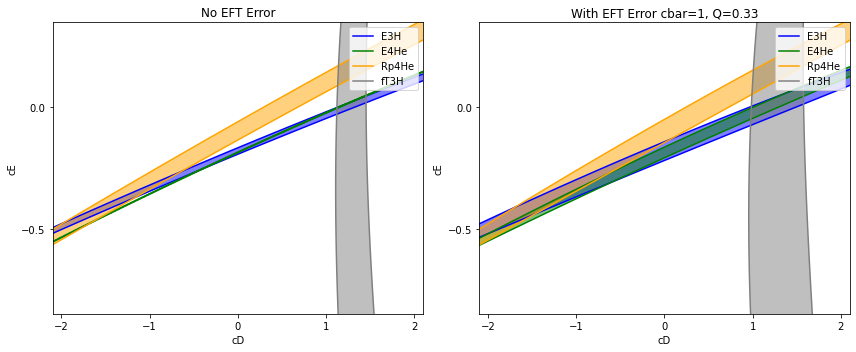

In [21]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 6a)
axs[0].set_title("No EFT Error")

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

axs[0].minorticks_on()
axs[0].xaxis.set_ticks_position('both')
axs[0].yaxis.set_ticks_position('both')
axs[0].xaxis.set_minor_locator(MultipleLocator(0.5))  
axs[0].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].minorticks_on()
axs[1].xaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')
axs[1].xaxis.set_minor_locator(MultipleLocator(0.5))  
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))

quantities_noefterr = [pE3H_noefterr, pE4He_noefterr, pRp4He_noefterr, pfT3H_noefterr]
contour_levels_noefterr = [contour_level(quantity, 0.95) for quantity in quantities_noefterr]
colors = ['blue', 'green', 'orange', 'grey']
for quantity, level, color in zip(quantities_noefterr, contour_levels_noefterr, colors):
    axs[0].contourf(cD_eval, cE_eval, quantity, levels=[level, np.max(quantity)], colors=color, antialiased=True, alpha=0.5)
    axs[0].contour(cD_eval, cE_eval, quantity, levels=[level], colors=color, antialiased=True)

legend_labels = [
    mlines.Line2D([], [], color='blue', label='E3H'),
    mlines.Line2D([], [], color='green', label='E4He'),
    mlines.Line2D([], [], color='orange', label='Rp4He'),
    mlines.Line2D([], [], color='grey', label='fT3H')
]
axs[0].legend(handles=legend_labels)

axs[0].set_xlim([-2.1, 2.1])
axs[0].set_xticks([-2, -1, 0, 1, 2])
axs[0].set_xlabel('cD')

axs[0].set_ylim([-0.85, 0.35])
axs[0].set_yticks([-0.5, 0])
axs[0].set_ylabel('cE')

# 6b)
axs[1].set_title("With EFT Error cbar=1, Q=0.33")

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

quantities_efterr = [pE3H_efterr, pE4He_efterr, pRp4He_efterr, pfT3H_efterr]
contour_levels_efterr = [contour_level(quantity, 0.68) for quantity in quantities_efterr]
colors = ['blue', 'green', 'orange', 'grey']
for quantity, level, color in zip(quantities_efterr, contour_levels_efterr, colors):
    axs[1].contourf(cD_eval, cE_eval, quantity, levels=[level, np.max(quantity)], colors=color, antialiased=True, alpha=0.5)
    axs[1].contour(cD_eval, cE_eval, quantity, levels=[level], colors=color, antialiased=True)

legend_labels = [
    mlines.Line2D([], [], color='blue', label='E3H'),
    mlines.Line2D([], [], color='green', label='E4He'),
    mlines.Line2D([], [], color='orange', label='Rp4He'),
    mlines.Line2D([], [], color='grey', label='fT3H')
]
axs[1].legend(handles=legend_labels)

axs[1].set_xlim([-2.1, 2.1])
axs[1].set_xticks([-2, -1, 0, 1, 2])
axs[1].set_xlabel('cD')

axs[1].set_ylim([-0.85, 0.35])
axs[1].set_yticks([-0.5, 0])
axs[1].set_ylabel('cE')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

---

## Task 2

- Perform the inference using MCMC sampling (for example using the `emcee` package) and two different choices for the combined data likelihood that includes two (or four) observables:
  - Case 1: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He})\}$
  - Case 2: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He}), E(^3\mathrm{H}), fT(^3\mathrm{H})\}$
- Include the fixed EFT errors that were computed in the previous task.

### Bring the datasets in a nicer form

In [11]:
dataset1 = [[mu_E4He, mu_Rp4He], 
            [sigma_E4He_efterr, sigma_Rp4He_efterr],
            False]

dataset2 = [[mu_E4He, mu_Rp4He, mu_E3H, mu_fT3H], 
            [sigma_E4He_efterr, sigma_Rp4He_efterr, sigma_E3H_efterr, sigma_fT3H_efterr],
            True]

- You can assume that all errors are independent, which implies that the total likelihood is just a product of the individual ones.
- Represent the results in a corner plot. I.e., you will basically reproduce the result in Fig. 3 in the paper (which is conditioned on all four observables, i.e., Case 2). Your parameter distribution will be somewhat different partly due to the fixed model discrepancy.

### Define log_prior, log_likelihood and unnormalized posterior

In [12]:
# --- logprior ---

def log_prior(theta):
    cD, cE = theta
    prior_dist = stats.norm(0, 5)
    p1 = prior_dist.logpdf(cD)
    p2 = prior_dist.logpdf(cE)
    logprior = p1+p2
    return logprior

# --- loglikelihood ---

def log_likelihood(ytheo, mu, sigma):
    loglikelihood_dist = stats.norm(mu, sigma)
    loglikelihood = loglikelihood_dist.logpdf(ytheo)
    return loglikelihood

# --- logposterior ---

def log_posterior(theta, mu, sigma, full=False):
    E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(theta[0], theta[1])

    if full:
        data = [E4He_eval, Rp4He_eval]
    else:
        data = [E4He_eval, Rp4He_eval, E3H_eval, fT3H_eval]

    log_likelihoods = np.array(list(map(log_likelihood, data, mu, sigma))).sum(axis=0)
    return log_prior(theta)+log_likelihoods

In [15]:
# https://cforssen.gitlab.io/tif285-book/content/BayesianStatistics/MaxEnt/demo-MaxEnt.html
# https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

ndim = 2  # number of parameters in the model
nwalkers = 20    # number of MCMC walkers
nburn = 1000     # "burn-in" period to let chains stabilize
nsteps = 10000   # number of MCMC steps to take

# np.random.seed(2023)
cD_start = 5 * np.random.rand(nwalkers,1) - 2.5 # uniform random number between -2.5 and 2.5
cE_start = 2 * np.random.rand(nwalkers,1) - 1 # uniform random number between -1. and 1.
print("cD [min,max]: ", np.min(cD_start), " | ", np.max(cD_start))
print("cE [min,max]: ", np.min(cE_start), " | ", np.max(cE_start))
starting_guesses = np.hstack((cD_start, cE_start)) # has shape (nwalkers, ndim)

cD [min,max]:  -2.0053214391440433  |  2.479968600508893
cE [min,max]:  -0.9759234558596455  |  0.5581720348814618
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


In [49]:
def mcmc(starting_guesses, nwalkers,nsteps,nburn,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Start burn-in:")
    theta, _, _ = sampler.run_mcmc(starting_guesses, nburn, progress=True)
    sampler.reset()

    print("Start sampling:")
    pos, prob, state = sampler.run_mcmc(theta, nsteps, progress=True)

    return sampler, pos, prob, state

In [16]:
# Runtime ~ 1 minute
sampler, _, _, _ = mcmc(starting_guesses=starting_guesses,
                   nwalkers=nwalkers,
                   nsteps=nsteps,
                   nburn=nburn,
                   ndim=ndim,
                   lnprob=log_posterior,
                   data=dataset2)

Start burn-in:


100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


Start sampling:


100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


(20000,)


(array([  47.,  271., 1193., 3352., 5326., 5116., 3204., 1099.,  323.,
          69.]),
 array([-1.96822441, -1.66887662, -1.36952883, -1.07018105, -0.77083326,
        -0.47148548, -0.17213769,  0.1272101 ,  0.42655788,  0.72590567,
         1.02525345]),
 [<matplotlib.patches.Polygon at 0x7f336031eca0>])

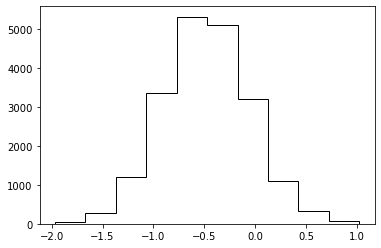

In [32]:
samples = sampler.get_chain(flat=True)
print(samples[:,1].shape) # cE
plt.hist(samples[:,1], color="k", histtype="step")

* Define functions for the `log_prior`, the `log_likelihood` and the `log_posterior`. The latter is provided as input to the `emcee` sampler. Note that the likelihood (and therefore the posterior) will depend on the choice of data set.
* Operating with log probabilities, the product of independent ones turns into a simple sum.
* `scipy.stats` provides a useful library for working with continuous variable distributions and for evaluating `logpdf`.
* It is probably worthwhile to test your `log_posterior` function before starting the MCMC sampling. 
* Consider beforehand how many samples you can afford to collect.
* The `show_titles=True` option to `corner` will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.

### Reproduce corner plot in figure 3

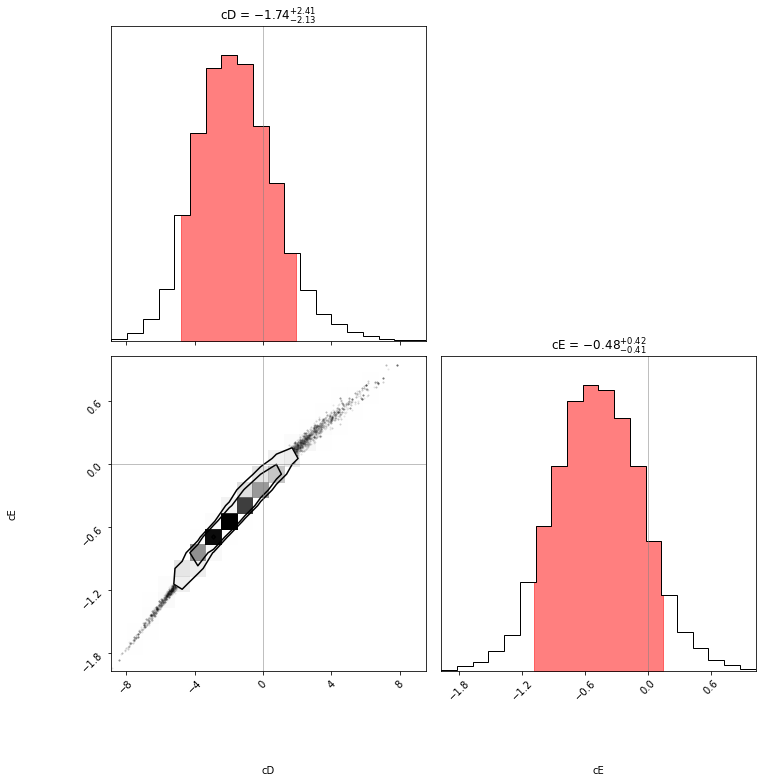

In [83]:
labels = ["cD", "cE"]

# Create a corner plot
figure = plt.figure(figsize=(12,12))
corner.corner(samples, labels=labels, show_titles=True, fig=figure)

confidence_level = 0.86
quantiles = [(1 - confidence_level) / 2, 1 - (1 - confidence_level) / 2]
# quantiles = [0.16, 0.5, 0.84]
quantile_values = np.quantile(samples, quantiles, axis=0)

# Plot vertical lines for the confidence interval
for i, ax in enumerate(figure.get_axes()):
    if i==0:
        # Top left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
#         ax.axvline(quantile_values[0, 0], color='red', linestyle='--', linewidth=2)
#         ax.axvline(quantile_values[1, 0], color='red', linestyle='--', linewidth=2)
        hist_corners = ax.get_children()[0].get_xy()
        idx0 = np.argmax(quantile_values[0, 0]<hist_corners[:,0]) - 1
        idx1 = np.argmax(quantile_values[1, 0]<hist_corners[:,0]) + 1
        x = np.copy(hist_corners[idx0:idx1,0])
        x[0] = quantile_values[0, 0]
        x[-1] = quantile_values[1, 0]
        y = np.copy(hist_corners[idx0:idx1,1])
        ax.fill_between(x, y, color='red', alpha=0.5)
    if i==2:
        # Bottom left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
        ax.axhline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
#         ax.set_xlim([-2, 2])  # Set the x-axis limits to [-2, 2]
#         ax.set_ylim([-0.6, 0.2])
    if i==3:
        # Bottom right
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
#         ax.axvline(quantile_values[0, 1], color='red', linestyle='--', linewidth=2)
#         ax.axvline(quantile_values[1, 1], color='red', linestyle='--', linewidth=2)
        hist_corners = ax.get_children()[0].get_xy()
        idx0 = np.argmax(quantile_values[0, 1]<hist_corners[:,0]) - 1
        idx1 = np.argmax(quantile_values[1, 1]<hist_corners[:,0]) + 1
        x = np.copy(hist_corners[idx0:idx1,0])
        x[0] = quantile_values[0, 1]
        x[-1] = quantile_values[1, 1]
        y = np.copy(hist_corners[idx0:idx1,1])
        ax.fill_between(x, y, color='red', alpha=0.5)

# Show the plot
plt.show()

## Task 3

- Use samples from the posterior distribution obtained with the fulll data set (Case 2 of Task 2) and produce a posterior predictive distribution for the four observables. That is, you should reproduce a result similar to the one shown in Fig. 4.
- Represent the results in a corner plot. I.e., you will basically reproduce the result in Fig. 4 in the paper. Your results will be somewhat different partly due to the fixed model discrepancy.
- As the predicted observables are the same ones that were used for calibrating the model (i.e., entering the likelihood), this should be considered as a form of model checking. We are testing that the model is consistent and that the data analysis worked.

Reproduce figure 4

In [ ]:
E4He_ppd, Rp4He_ppd, _, _, E3H_ppd, _, fT3H_ppd = vfewnucleonEmulator(samples[:,0], samples[:,1])

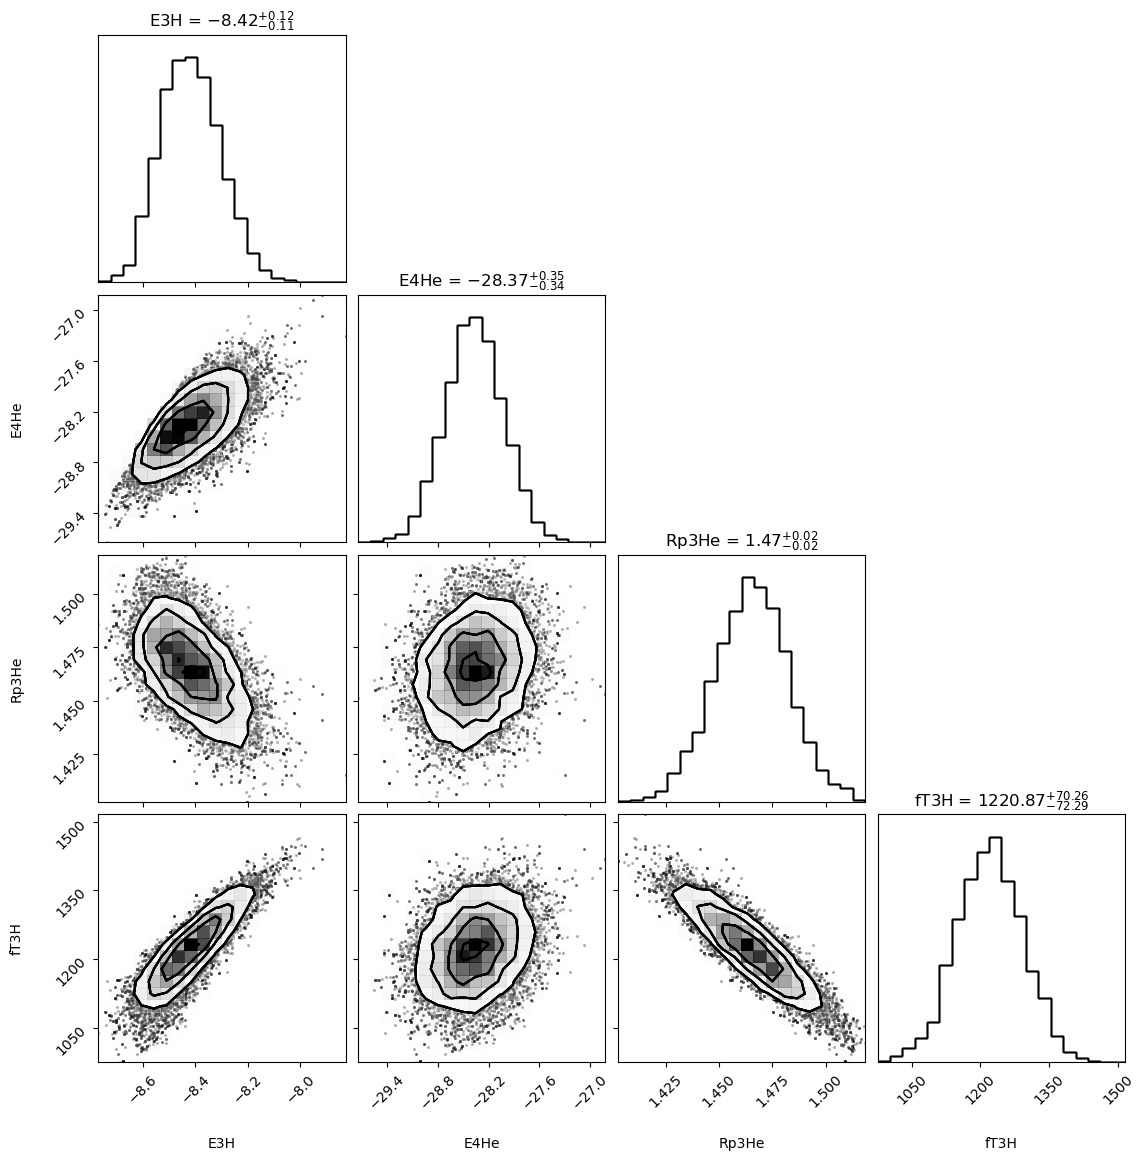

In [ ]:
ppd = np.array([E3H_ppd,E4He_ppd,Rp4He_ppd,fT3H_ppd]).T
labels = ["E3H","E4He","Rp3He","fT3H"]

# Create a corner plot
corner.corner(ppd, labels=labels, show_titles=True, fig=figure)

## Extra Task